In [ ]:
!pip install voxelmorph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 1.8 MB/s 
     |████████████████████████████████| 108 kB 9.8 MB/s 


In [ ]:
# imports
import os, sys



# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'



# local imports
import voxelmorph as vxm
import neurite as ne

In [ ]:
# download MRI tutorial data
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz

--2022-08-08 18:54:33--  https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16644702 (16M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  15.87M  25.9MB/s    in 0.6s    

2022-08-08 18:54:34 (25.9 MB/s) - ‘data.tar.gz’ saved [16644702/16644702]

brain_2d_no_smooth.h5
brain_2d_smooth.h5
brain_3d.h5
fs_rgb.npy
subj1.npz
subj2.npz
tutorial_data.npz


In [ ]:
npz = np.load('tutorial_data.npz')
x_train = npz['train']
x_val = npz['validate']


# the 208 volumes are of size 160x192
vol_shape = x_train.shape[1:]
print('train shape:', x_train.shape)

train shape: (208, 192, 160)


In [ ]:
# ./scripts/tf/test.py --model model.h5 --atlas atlas.npz --scans scan01.npz scan02.npz scan03.npz --labels labels.npz

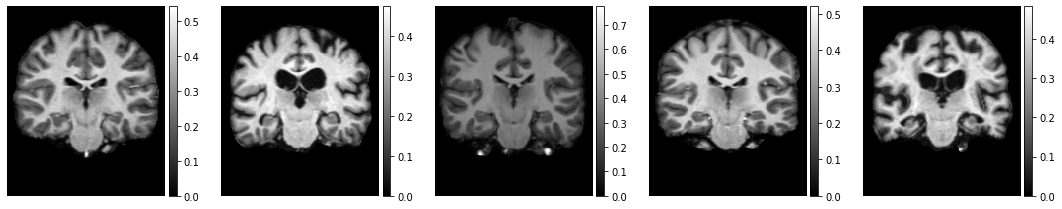

In [ ]:
# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [ ]:
import tensorflow.keras.backend as K

class MSE:

    def __init__(self, image_sigma=1.0):
        self.image_sigma = image_sigma

    # def loss(self, y_true, y_pred):
    #     mse = K.square(y_true - y_pred)
    #     mse = K.mean(mse)
    #     return 1.0 / (self.image_sigma ** 2) * mse
    def loss(self, y_true, y_pred):
      mse = K.square(abs(y_true - y_pred) / y_true)
      mse = K.mean(mse)
      return 1.0 / (self.image_sigma ** 2) * mse

In [ ]:
# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# unet
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
# losses = ['mse', vxm.losses.Grad('l2').loss]
losses = ['MSE']
loss_weights = [1, 0.01]

In [ ]:
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


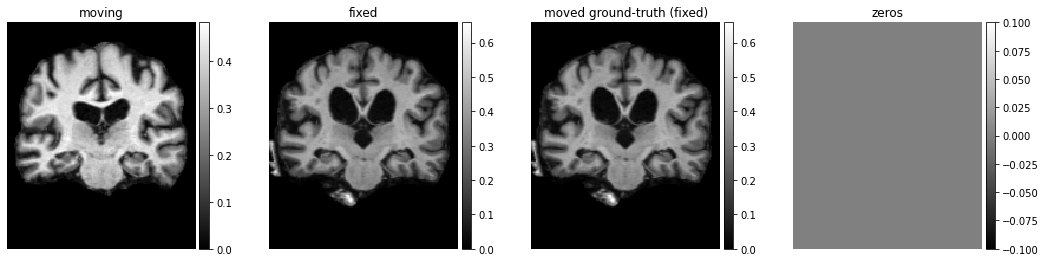

In [ ]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)



# let's test it
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2);

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


5/5 - 16s - loss: 0.0069 - vxm_dense_transformer_loss: 0.0069 - 16s/epoch - 3s/step
Epoch 2/5
5/5 - 12s - loss: 0.0065 - vxm_dense_transformer_loss: 0.0065 - 12s/epoch - 2s/step
Epoch 3/5
5/5 - 12s - loss: 0.0066 - vxm_dense_transformer_loss: 0.0066 - 12s/epoch - 2s/step
Epoch 4/5
5/5 - 12s - loss: 0.0070 - vxm_dense_transformer_loss: 0.0070 - 12s/epoch - 2s/step
Epoch 5/5
5/5 - 12s - loss: 0.0076 - vxm_dense_transformer_loss: 0.0076 - 12s/epoch - 2s/step


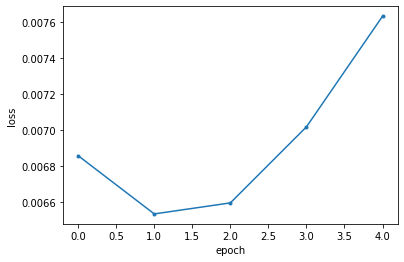

In [ ]:
# as before, let's visualize what happened
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

In [ ]:
# load pretrained model weights
vxm_model.load_weights('brain_2d_smooth.h5')
# vxm_model.load_weights('brain_2d_no_smooth.h5')

In [ ]:
# vxm_model.save("vxm_model.h5")

In [ ]:
# create the validation data generator
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

In [ ]:
# prediction
val_pred = vxm_model.predict(val_input)

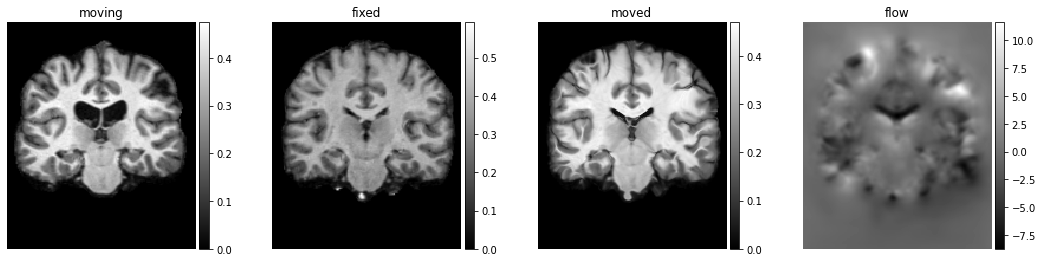

In [ ]:
# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
# %timeit is a 'jupyter magic' that times the given line over several runs
%timeit vxm_model.predict(val_input)

10 loops, best of 5: 120 ms per loop


In [ ]:
# import pickle as pl

# myfile = "brain_3d.h5"
# with open(myfile, 'rb') as handle:
#      my_array = pl.load(handle)
# data = np.array(my_array)

UnpicklingError: ignored

In [ ]:
# import pickle

# br = np.load('brain_3d.h5', allow_pickle = True)


# model = vxm.networks.VxmDense.load(br, input_model=None)
# registration_model = model.get_registration_model()
# inshape = registration_model.inputs[0].shape[1:-1]
# transform_model = vxm.networks.Transform(inshape, interp_method='nearest')

OSError: ignored

In [ ]:
# val_input
# arow = len(val_input)
# acol = len(val_input[0])
# print(arow)
# print(acol)
# print("Rows : " + str(arow))
# print("Columns : " + str(acol))

np.shape(val_input)


# np.shape(val_pred)

# arow = len(val_pred)
# acol = len(val_pred[0])
# print(arow)
# print(acol)
# print("Rows : " + str(arow))
# print("Columns : " + str(acol))



# arr = np.array(val_pred)

# print(np.shape(arr))

(2, 1, 192, 160, 1)

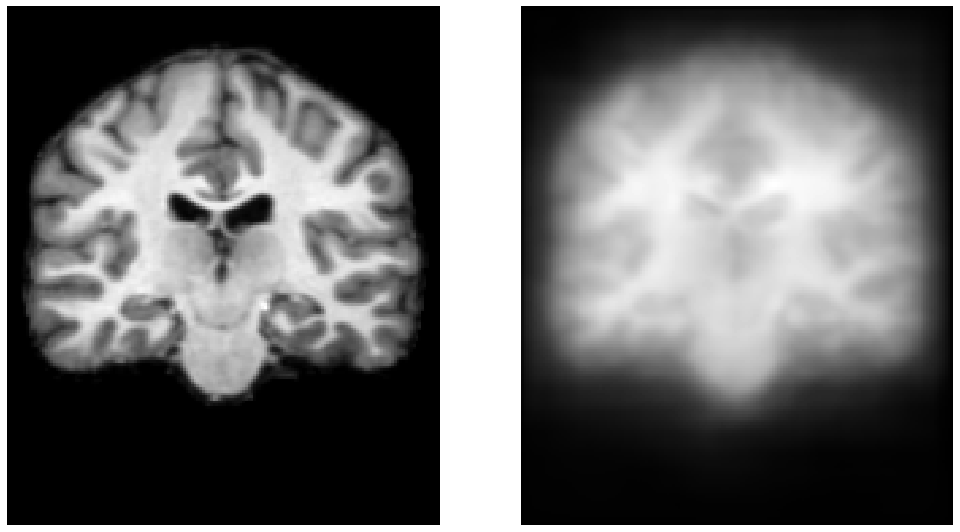

In [ ]:
images = [img[0, :, :, 0] for img in val_pred]
ne.plot.slices(images);

In [ ]:
val_pred

[array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]]], dtype=float32), array([[[[ 0.00354997, -0.00345502],
          [ 0.004409  , -0.00429385],
          [ 0.00493981, -0.00480921],
          ...,
          [ 0.00464946, -0.00450673],
          [ 0.00441002, -0.0042904 ],
          [ 0.00361018, -0.00353591]],
 
         [[ 0.00422495, -0.00412939],
 

In [ ]:
val_input * val_pred

TypeError: ignored

In [ ]:
#load images
y_pred = val_pred
y_true = val_input


def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

dice_score = dice_coef(y_true, y_pred)
print ("Dice Similarity: {}".format(dice_score))

ValueError: ignored

In [ ]:
# get the data
!wget wget http://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar -O data.tar
!tar -xf data.tar;

--2022-07-02 20:08:03--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2022-07-02 20:08:03--  http://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar [following]
--2022-07-02 20:08:03--  https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24903680 (24M) [application/x-tar]
Saving to: ‘data.tar’

data.tar            100%[===================>]  23.75M  54.0MB/s    in 0.4s    

2022-07-0

In [ ]:
#load images
y_pred = val_pred
y_true = val_input

# Dice similarity function
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

dice_score = dice(y_pred, y_true, k = 255) #255 in my case, can be 1 
print ("Dice Similarity: {}".format(dice_score))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: ignored

In [ ]:
model = 'brain_2d_smooth.h5'

# load model and build nearest-neighbor transfer model
model = vxm.networks.VxmDense.load(model, input_model=None)
registration_model = model.get_registration_model()
inshape = registration_model.inputs[0].shape[1:-1]
transform_model = vxm.networks.Transform(inshape, interp_method='nearest')

moving_seg = val_input
warp = val_pred

warped_seg = transform_model.predict([moving_seg, warp]).squeeze()

/usr/local/lib/python3.7/dist-packages/voxelmorph/tf/networks.py:124: UserWarning: int_downsize is deprecated, use the int_resolution parameter.
  warnings.warn('int_downsize is deprecated, use the int_resolution parameter.')


ValueError: ignored

In [ ]:
def dice(array1, array2, labels=None, include_zero=True):
    """
    Computes the dice overlap between two arrays for a given set of integer labels.
    Parameters:
        array1: Input array 1.
        array2: Input array 2.
        labels: List of labels to compute dice on. If None, all labels will be used.
        include_zero: Include label 0 in label list. Default is False.
    """
    if labels is None:
        labels = np.concatenate([np.unique(a) for a in [array1, array2]])
        # labels = np.sort(np.unique(labels))
        # labels = array1 + array2
        # print(labels)
        # print("haha")
    if not include_zero:
        labels = np.delete(labels, np.argwhere(labels == 0)) 
        # print("haha2")
    # print("hahahha")
    print(len(labels))
    # print("hahahaha")

    dicem = np.zeros(len(labels))
    for idx, label in enumerate(labels):
        top = 2 * np.sum(np.logical_and(array1 == label, array2 == label))
        bottom = np.sum(array1 == label) + np.sum(array2 == label)
        bottom = np.maximum(bottom, np.finfo(float).eps)  # add epsilon
        dicem[idx] = top / bottom
    return dicem


warped_seg = val_pred
fixed_seg = val_input
# labels = [100000, 100000, 1, 2, 3, 4, 5, 6,7,8,9,10,11,12,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5]
# labels = vxm.data/labels.npz
# npz = np.load('tutorial_data.npz')
# labels = np.load('labels.npy')
# labels = np.load('labels.npz')
labels = None
# labels = npz['labels']
# labels = /content/labels.npy


dice_means = [] 
# overlap = dice(warped_seg, fixed_seg)
overlap = dice(val_pred, val_input)
dice_means.append(np.mean(overlap))

# print('Avg Dice: %.4f +/- %.4f' % (np.mean(dice_means), np.std(dice_means)))

print('Dice: %.100f +/- %.100f' % (np.mean(dice_means), np.std(dice_means)))

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


ValueError: ignored

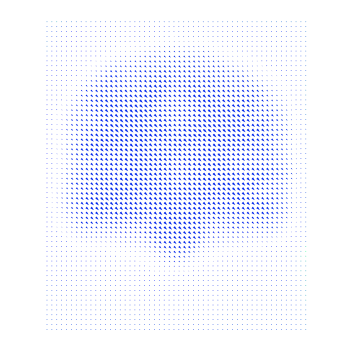

In [ ]:
# visualize flow
flow = val_pred[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);